In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [35]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [36]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [37]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [38]:
logdir=pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [39]:
higgsgz=tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [40]:
features=28

In [41]:
dataset=tf.data.experimental.CsvDataset(higgsgz,
                                      [float(),]*(features+1),
                                      compression_type="GZIP")

In [42]:
def pack_row(*row):
    label=row[0]
    features=tf.stack(row[1:],1)
    return features,label

In [43]:
packed_dataset=dataset.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


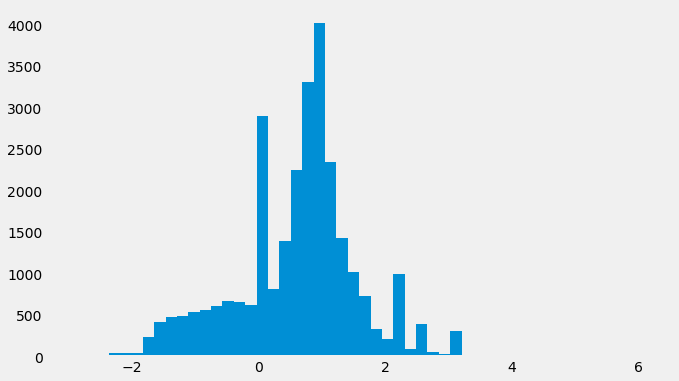

In [44]:
for features,label in packed_dataset.batch(1000).take(1):
    print(features[0])
    plt.figure(figsize=(10,6))
    plt.grid(False)
    plt.hist(features.numpy().flatten(),bins=50)

In [45]:
no_validation=int(1e3)
no_training=int(1e4)
buffer_size=int(1e4)
batch_size=500
steps_per_epoch=no_training/batch_size

In [46]:
validation_data=packed_dataset.take(no_validation).cache()
training_data=packed_dataset.skip(no_validation).take(no_training).cache()

In [47]:
training_data

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [48]:
validation_batch=validation_data.batch(batch_size)
training_batch=training_data.shuffle(buffer_size).repeat().batch(batch_size)

In [49]:
training_batch

<BatchDataset shapes: ((None, 28), (None,)), types: (tf.float32, tf.float32)>

In [50]:
learning_rate_schedule=tf.keras.optimizers.schedules.InverseTimeDecay(
                       0.001,
                       decay_steps=steps_per_epoch*1000,
                       decay_rate=0.1,
                       staircase=False)

In [51]:
def get_optimizer():
    return tf.keras.optimizers.Adam(learning_rate_schedule)

Text(0, 0.5, 'Learning Rate')

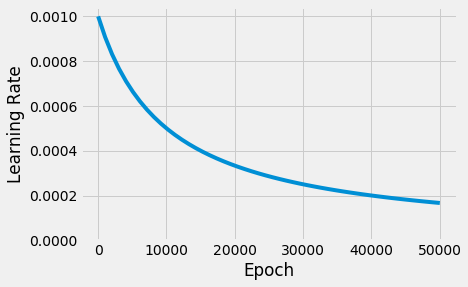

In [52]:
steps=np.linspace(0,1000000)
len(steps)
lr=learning_rate_schedule(steps)
plt.plot(steps/steps_per_epoch,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

In [53]:
def get_callbacks(name):
    return [tfdocs.modeling.EpochDots(),
           tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
           tf.keras.callbacks.TensorBoard(logdir/name)]

In [54]:
def compile_and_fit(model,name,optimizer=None,max_epochs=10000):
    if optimizer is None:
        optimizer=get_optimizer()
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                             name='binary_crossentropy'),
                                                             'accuracy'])
    model.summary()
    
    history=model.fit(training_batch,
                     steps_per_epoch=steps_per_epoch,
                     epochs=max_epochs,
                     validation_data=validation_batch,
                     callbacks=get_callbacks(name),
                     verbose=0)
    return history

In [55]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu',input_shape=(28,)),
    layers.Dense(1)
])

In [56]:
size_histories={}

In [57]:
size_histories['Tiny']=compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4835,  binary_crossentropy:0.7768,  loss:0.7768,  val_accuracy:0.4810,  val_binary_crossentropy:0.7607,  val_loss:0.7607,  
....................................................................................................
Epoch: 100, accuracy:0.6049,  binary_crossentropy:0.6245,  loss:0.6245,  val_accuracy:0.5920,  val_binary_crossentropy:0.6258,  val_loss:0.6258,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

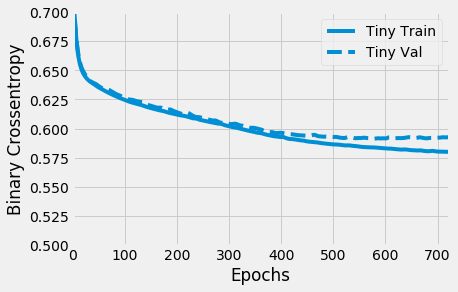

In [58]:
plotter=tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [59]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu',input_shape=(28,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

In [60]:
size_histories['Small']=compile_and_fit(small_model,'sizes/Small')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4589,  binary_crossentropy:0.7843,  loss:0.7843,  val_accuracy:0.4290,  val_binary_crossentropy:0.7441,  val_loss:0.7441,  
....................................................................................................
Epoch: 100, accuracy:0.6167,  binary_crossentropy:0.6176,  loss:0.6176,  val_accuracy:0.6000,  val_binary_crossentropy:0.6184,  val_loss:0.

In [61]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu',input_shape=(28,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

In [62]:
size_histories['Medium']=compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4892,  binary_crossentropy:0.7013,  loss:0.7013,  val_accuracy:0.4770,  val_binary_crossentropy:0.6804,  val_loss:0.6804,  
....................................................................................................
E

In [63]:
Large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',input_shape=(28,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

In [64]:
size_histories['Large']=compile_and_fit(Large_model,'sizes/Large')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5059,  binary_crossentropy:0.7803,  loss:0.7803,  val_accuracy:0.5460,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

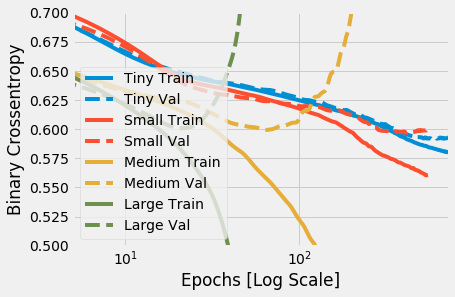

In [65]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [66]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
%tensorboard --logdir {logdir}/sizes

Reusing TensorBoard on port 6006 (pid 3092), started 0:37:17 ago. (Use '!kill 3092' to kill it.)

In [75]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [76]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/personal/AppData/Local/Temp/tmpbcsjjhty/tensorboard_logs/regularizers/Tiny')

In [77]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [78]:
l2_model=tf.keras.Sequential([
    layers.Dense(512,activation='elu',
                kernel_regularizer=regularizers.l2(0.001),
                input_shape=(28,)),
    layers.Dense(512,activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

In [79]:
regularizer_histories['l2']=compile_and_fit(l2_model,"regularizers/l2")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5067,  binary_crossentropy:0.8196,  loss:2.3346,  val_accuracy:0.4680,  val_binary_crossentr

In [80]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(28,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [81]:
regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)              

(0.5, 0.7)

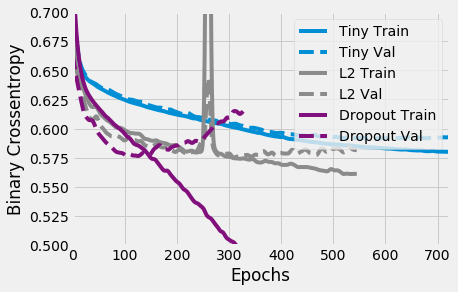

In [82]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [83]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(28,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [84]:
regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)             

(0.5, 0.7)

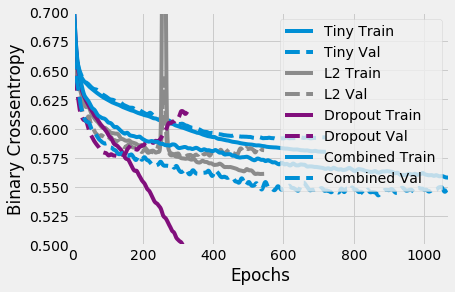

In [85]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [86]:
%tensorboard --logdir {logdir}/regularizers

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 14220.